# GANS model for image generation using MNIST Dataset

- This GANS model is trained on the MNIST dataset. The Generator is trained on noise data and the loss computed helps learn the appropriate latent space.
- Increasing the number of epochs and utilzing more than one loss value helps avoid mode collapse.
- The GANS model successfully learns the latent space to generate more hand-written digit samples with different variations

The Generator creates more images and the discriminator learns to classify whether the image is real or fake. Based on the discriminators results, the generator is then used to create more samples and the this process is repeated with each epoch. The goal for the discriminator is set to ensure that the generator produced images are easy to identify whereas the generator is incentivised to learn to produce images that the discriminator is unable to identify as fake.

MNIST Dataset
The MNIST dataset is a famous dataset in the field of machine learning. It consists of 28x28 pixel grayscale images of handwritten digits (0-9). The dataset contains 60,000 training images and 10,000 test images, making it a suitable choice for various machine learning tasks, including digit classification and image generation.

Its significance lies in its simplicity, making it a benchmark dataset for testing new machine learning algorithms and models. Researchers and developers often use MNIST as a starting point for experimenting with deep learning techniques because of its small size and easy-to-understand structure.

### Introduction to GANs
Generative Adversarial Networks (GANs) are a class of deep learning models designed for generative tasks. They consist of two key components: the Generator and the Discriminator. The Generator attempts to create data (e.g., images) from random noise, while the Discriminator aims to distinguish between real data and fake data produced by the Generator.

In a GAN, these two networks are trained simultaneously through a competitive process. The Generator gets better at creating data that mimics the real data distribution over time, and the Discriminator gets better at distinguishing real from fake data. This adversarial process helps the Generator improve its ability to generate realistic data, making GANs especially useful for image generation tasks.

Generative Adversarial Networks (GANs) are a class of deep learning models designed for generative tasks. They consist of two key components: the Generator and the Discriminator. The Generator attempts to create data (e.g., images) from random noise, while the Discriminator aims to distinguish between real data and fake data produced by the Generator.

In a GAN, these two networks are trained simultaneously through a competitive process. The Generator gets better at creating data that mimics the real data distribution over time, and the Discriminator gets better at distinguishing real from fake data. This adversarial process helps the Generator improve its ability to generate realistic data, making GANs especially useful for image generation tasks.

## Challenges faced and future updates
- The model is a generalized one and can be used to generate more hand-written digit samples, or further customized to use conditions to produce completely different results
- Limited Data and the computational complexity of training 2 models at each epoch makes the training process cumbersome and time consuming. This model used the MNIST dataset which has input data that can be managed on limited resources but the model can easily be scaled up to handle more datasets and use cases


### Load packages

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



### Load Dataset

In [3]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 14319362.73it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28959047.05it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24246378.05it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



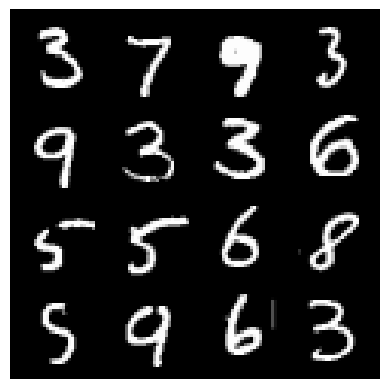

In [10]:
# Here are sample images from the dataset
sample_images, _ = next(iter(dataloader))
sample_images_grid = torchvision.utils.make_grid(sample_images[:16], nrow=4, padding=2, normalize=True)
plt.imshow(sample_images_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()


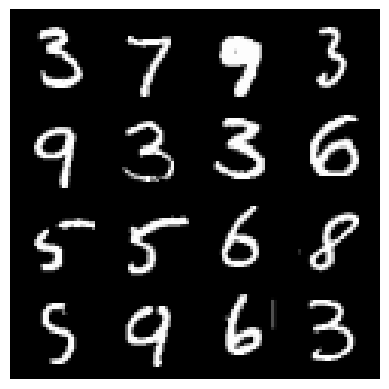

### Defining the GANS model

Generator Architecture
The Generator typically starts with a random noise vector (latent space) and uses fully connected layers followed by activations to gradually upsample the data until it reaches the desired image size (e.g., 28x28 for MNIST). The Tanh activation function is often used as the final activation to ensure the output is in the range [-1, 1].

Discriminator Architecture
The Discriminator takes an image as input and uses fully connected layers with LeakyReLU activation to process the image. The final layer has a Sigmoid activation, which produces a probability score indicating whether the input image is real or fake.

In [11]:
# Define the generator and discriminator networks
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

### Train the model

![Example Image](gans.jpg)


In [12]:
# Hyperparameters
latent_dim = 100
image_size = 28 * 28
batch_size = 64
epochs = 200

# Define GAN components
generator = Generator(latent_dim, image_size)
discriminator = Discriminator(image_size)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.view(-1, image_size)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Discriminator on real data
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_real.backward()

        # Discriminator on fake data
        noise = torch.randn(batch_size, latent_dim)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()

        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if i % 400 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss_real + d_loss_fake:.4f}] [G loss: {g_loss:.4f}]"
            )




[Epoch 0/200] [Batch 0/938] [D loss: 1.3573] [G loss: 0.6971]
[Epoch 0/200] [Batch 400/938] [D loss: 0.3701] [G loss: 1.6848]
[Epoch 0/200] [Batch 800/938] [D loss: 0.7323] [G loss: 1.1851]
[Epoch 1/200] [Batch 0/938] [D loss: 1.2115] [G loss: 0.8353]


### Evaluate trained model

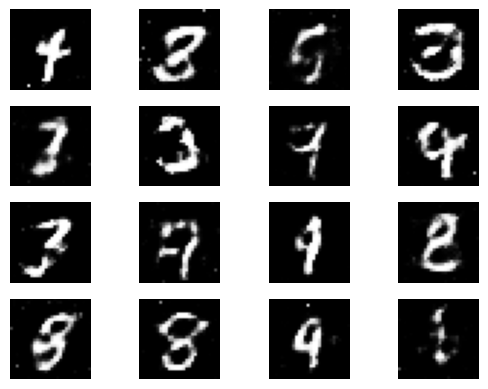

In [11]:
# Generate some samples
generator.eval()
with torch.no_grad():
    noise = torch.randn(16, latent_dim)
    generated_images = generator(noise).view(-1, 1, 28, 28)

# Display generated images
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[i * 4 + j][0], cmap='gray')
        axs[i, j].axis('off')
plt.show()

### Load packages
torch: PyTorch is a deep learning framework for building and training neural networks.

torch.nn: PyTorch's neural network module for defining neural network architectures.

torch.optim: PyTorch's optimization library for defining optimizers (e.g., Adam).

datasets, transforms: These modules from torchvision provide tools for working with datasets and data transformations.

DataLoader: Helps in loading and batching data.

matplotlib.pyplot: Used for data visualization.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



### Load Dataset

setting up a batch size, transforming the images to tensors, and normalizing them. This normalization scales the pixel values to the range [-1, 1], which helps training stability by making it easier for the generator and discriminator to work with.


In [ ]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)


### Define GANS model

In [ ]:
# Define the generator and discriminator networks
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

### Train the model

![Example Image](gans.jpg)


In [ ]:
# Hyperparameters
latent_dim = 100
image_size = 28 * 28
batch_size = 64
epochs = 200

# Define GAN components
generator = Generator(latent_dim, image_size)
discriminator = Discriminator(image_size)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.view(-1, image_size)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Discriminator on real data
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_real.backward()

        # Discriminator on fake data
        noise = torch.randn(batch_size, latent_dim)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()

        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if i % 400 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss_real + d_loss_fake:.4f}] [G loss: {g_loss:.4f}]"
            )




[Epoch 0/200] [Batch 0/938] [D loss: 1.4923] [G loss: 0.7233]
[Epoch 0/200] [Batch 400/938] [D loss: 0.3500] [G loss: 1.6733]
[Epoch 0/200] [Batch 800/938] [D loss: 0.5132] [G loss: 1.5455]
[Epoch 1/200] [Batch 0/938] [D loss: 0.9343] [G loss: 1.0075]
[Epoch 1/200] [Batch 400/938] [D loss: 0.5019] [G loss: 1.7916]
[Epoch 1/200] [Batch 800/938] [D loss: 1.4473] [G loss: 0.9222]
[Epoch 2/200] [Batch 0/938] [D loss: 1.2990] [G loss: 1.0677]
[Epoch 2/200] [Batch 400/938] [D loss: 0.6028] [G loss: 1.8023]
[Epoch 2/200] [Batch 800/938] [D loss: 1.1654] [G loss: 1.0446]
[Epoch 3/200] [Batch 0/938] [D loss: 1.0882] [G loss: 1.0154]
[Epoch 3/200] [Batch 400/938] [D loss: 0.6362] [G loss: 1.4521]
[Epoch 3/200] [Batch 800/938] [D loss: 1.1621] [G loss: 0.9706]
[Epoch 4/200] [Batch 0/938] [D loss: 0.7066] [G loss: 1.3890]
[Epoch 4/200] [Batch 400/938] [D loss: 1.0623] [G loss: 1.0505]
[Epoch 4/200] [Batch 800/938] [D loss: 1.1096] [G loss: 1.0489]
[Epoch 5/200] [Batch 0/938] [D loss: 0.7339] [G lo

[Epoch 42/200] [Batch 800/938] [D loss: 0.7787] [G loss: 1.6692]
[Epoch 43/200] [Batch 0/938] [D loss: 1.2823] [G loss: 1.0931]
[Epoch 43/200] [Batch 400/938] [D loss: 1.1284] [G loss: 1.6406]
[Epoch 43/200] [Batch 800/938] [D loss: 0.9933] [G loss: 1.5450]
[Epoch 44/200] [Batch 0/938] [D loss: 1.4847] [G loss: 1.3778]
[Epoch 44/200] [Batch 400/938] [D loss: 1.2457] [G loss: 1.5147]
[Epoch 44/200] [Batch 800/938] [D loss: 1.1018] [G loss: 1.3567]
[Epoch 45/200] [Batch 0/938] [D loss: 1.2055] [G loss: 1.2736]
[Epoch 45/200] [Batch 400/938] [D loss: 1.2154] [G loss: 1.4003]
[Epoch 45/200] [Batch 800/938] [D loss: 1.0609] [G loss: 1.4392]
[Epoch 46/200] [Batch 0/938] [D loss: 0.9187] [G loss: 1.7039]
[Epoch 46/200] [Batch 400/938] [D loss: 1.1331] [G loss: 1.5653]
[Epoch 46/200] [Batch 800/938] [D loss: 1.1742] [G loss: 1.1634]
[Epoch 47/200] [Batch 0/938] [D loss: 1.0592] [G loss: 1.8188]
[Epoch 47/200] [Batch 400/938] [D loss: 1.1813] [G loss: 1.7291]
[Epoch 47/200] [Batch 800/938] [D l

[Epoch 85/200] [Batch 400/938] [D loss: 0.7121] [G loss: 2.9420]
[Epoch 85/200] [Batch 800/938] [D loss: 0.5477] [G loss: 2.3070]
[Epoch 86/200] [Batch 0/938] [D loss: 0.9857] [G loss: 2.2161]
[Epoch 86/200] [Batch 400/938] [D loss: 0.7905] [G loss: 2.4105]
[Epoch 86/200] [Batch 800/938] [D loss: 0.7857] [G loss: 2.3881]
[Epoch 87/200] [Batch 0/938] [D loss: 1.0295] [G loss: 1.7276]
[Epoch 87/200] [Batch 400/938] [D loss: 1.2562] [G loss: 1.9943]
[Epoch 87/200] [Batch 800/938] [D loss: 1.2948] [G loss: 1.2701]
[Epoch 88/200] [Batch 0/938] [D loss: 1.2176] [G loss: 1.9955]
[Epoch 88/200] [Batch 400/938] [D loss: 0.9047] [G loss: 2.1490]
[Epoch 88/200] [Batch 800/938] [D loss: 0.9606] [G loss: 1.9446]
[Epoch 89/200] [Batch 0/938] [D loss: 1.4325] [G loss: 1.4195]
[Epoch 89/200] [Batch 400/938] [D loss: 1.3098] [G loss: 1.3578]
[Epoch 89/200] [Batch 800/938] [D loss: 1.0547] [G loss: 1.9187]
[Epoch 90/200] [Batch 0/938] [D loss: 1.1780] [G loss: 1.3718]
[Epoch 90/200] [Batch 400/938] [D l

[Epoch 127/200] [Batch 800/938] [D loss: 1.1460] [G loss: 1.2901]
[Epoch 128/200] [Batch 0/938] [D loss: 1.1258] [G loss: 1.4487]
[Epoch 128/200] [Batch 400/938] [D loss: 1.1154] [G loss: 1.4923]
[Epoch 128/200] [Batch 800/938] [D loss: 1.3534] [G loss: 1.2581]
[Epoch 129/200] [Batch 0/938] [D loss: 1.1694] [G loss: 1.4245]
[Epoch 129/200] [Batch 400/938] [D loss: 0.8527] [G loss: 1.8962]
[Epoch 129/200] [Batch 800/938] [D loss: 1.0965] [G loss: 1.3408]
[Epoch 130/200] [Batch 0/938] [D loss: 1.2680] [G loss: 1.6648]
[Epoch 130/200] [Batch 400/938] [D loss: 0.9057] [G loss: 1.5957]
[Epoch 130/200] [Batch 800/938] [D loss: 0.9096] [G loss: 1.6224]
[Epoch 131/200] [Batch 0/938] [D loss: 1.3572] [G loss: 1.3312]
[Epoch 131/200] [Batch 400/938] [D loss: 0.7925] [G loss: 1.4958]
[Epoch 131/200] [Batch 800/938] [D loss: 1.0049] [G loss: 1.5980]
[Epoch 132/200] [Batch 0/938] [D loss: 0.7571] [G loss: 2.0297]
[Epoch 132/200] [Batch 400/938] [D loss: 0.9730] [G loss: 1.8725]
[Epoch 132/200] [Bat

[Epoch 169/200] [Batch 800/938] [D loss: 0.9880] [G loss: 1.3597]
[Epoch 170/200] [Batch 0/938] [D loss: 1.0729] [G loss: 1.1512]
[Epoch 170/200] [Batch 400/938] [D loss: 1.0358] [G loss: 1.3706]
[Epoch 170/200] [Batch 800/938] [D loss: 1.0181] [G loss: 1.5633]
[Epoch 171/200] [Batch 0/938] [D loss: 0.8457] [G loss: 1.7241]
[Epoch 171/200] [Batch 400/938] [D loss: 0.9900] [G loss: 1.5166]
[Epoch 171/200] [Batch 800/938] [D loss: 1.1544] [G loss: 1.2419]
[Epoch 172/200] [Batch 0/938] [D loss: 1.1398] [G loss: 1.7057]
[Epoch 172/200] [Batch 400/938] [D loss: 1.0269] [G loss: 1.3319]
[Epoch 172/200] [Batch 800/938] [D loss: 0.9595] [G loss: 1.7513]
[Epoch 173/200] [Batch 0/938] [D loss: 1.1520] [G loss: 1.4245]
[Epoch 173/200] [Batch 400/938] [D loss: 0.8725] [G loss: 1.3004]
[Epoch 173/200] [Batch 800/938] [D loss: 1.0722] [G loss: 1.5348]
[Epoch 174/200] [Batch 0/938] [D loss: 0.9709] [G loss: 1.6795]
[Epoch 174/200] [Batch 400/938] [D loss: 1.2020] [G loss: 1.1559]
[Epoch 174/200] [Bat

### Evaluate trained model

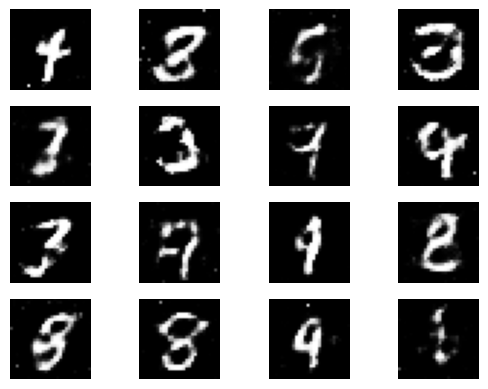

In [ ]:
# Generate some samples
generator.eval()
with torch.no_grad():
    noise = torch.randn(16, latent_dim)
    generated_images = generator(noise).view(-1, 1, 28, 28)

# Display generated images
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[i * 4 + j][0], cmap='gray')
        axs[i, j].axis('off')
plt.show()